In [3]:
import math
import numpy as np
import scipy
from scipy.fft import dct
import matplotlib.pyplot as plt
from idesolver import IDESolver

import torch
from torch import nn
import torch.optim as optim

from volterra import *
from probability import *
from spectral_transforms import *
from aaa_algorithms import *

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Fourier Volterra inversion positive definite kernel

In [5]:
c0_re = np.random.randn()
c0_im = 0# np.random.rand() # Im[c0] >= 0
c0 = c0_re + 1j*c0_im
c1 = 0 #np.random.rand() # c1 >= 0

print("c0 = ", c0)
print("c1 = ", c1)

T = 10
Nt = 1000
t = np.linspace(0, T, Nt)
dt = t[1] - t[0]
Nt = len(t)

c0 =  (1.7886871683631156+0j)
c1 =  0


In [240]:
# Volterra kernel
lmbda_a = 100*np.sort(np.random.rand(100))
lmbda_b = np.random.rand(len(lmbda_a))

# Symmetrize spectral distribution
#lmbda_a, lmbda_b = symmetrize_dist(lmbda_a, lmbda_b, halve_center=True)
#assert(np.linalg.norm(lmbda_a + np.flip(lmbda_a)) < 1e-10)
#assert(np.linalg.norm(lmbda_b - np.flip(lmbda_b)) < 1e-10)

#lmbda_a = np.linspace(0, 5, 1000)
#lmbda_b = np.exp(-lmbda_a**2/10)
#lmbda_b /= np.sum(lmbda_b)

lmbda = Distribution(None, lmbda_a, lmbda_b)

K = complex_exp_kernel(lmbda, t)

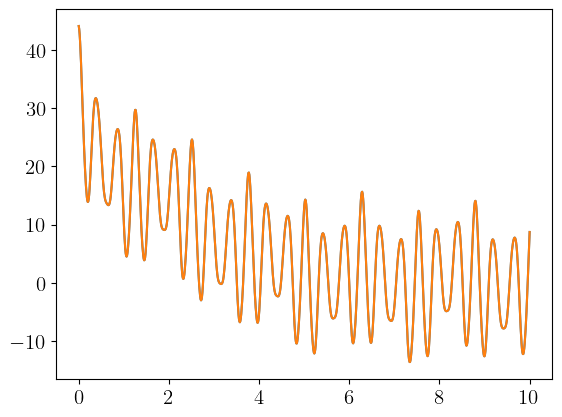

9.894073098921287e-06


In [106]:
# Volterra kernel
K = 20*np.exp(-t**2/10) + 8.7*np.exp(-math.pi*t) + 10*np.cos(15*t) + 3.2*np.cos(20*t) + 1.5*np.cos(3*t) + 0.5*np.cos(40*t) + 0.2*np.cos(3.8*t)
#K = 4*np.exp(-t**2/0.01)# + 2*np.exp(-(t - 3)**2/0.01) + np.exp(-(t - 5)**2/0.01)
#K = np.exp(-0.1*t**2) + np.exp(-t**2) + np.exp(-t) + np.exp(-0.1*t)
#K = np.cos(2*t) + np.cos(4*t) + np.cos(6*t) + np.cos(8*t) + np.cos(10*t)
#K = np.exp(-t) + np.exp(-2*t) + 2*np.cos(10*t) + 1*np.cos(1*t) + 2*np.cos(0.1*t)
#K = np.cos(t)

lmbda_a = math.pi*(2*np.arange(Nt)+1)/(2*Nt*dt)
lmbda_b = np.sqrt(2/Nt)*dct(K, type=3, norm='ortho', orthogonalize=False)
lmbda_b[lmbda_b < 0] = 0

lmbda_a, lmbda_b = fit_cosine_sum(K, t, len(lmbda_a), omegas_init=lmbda_a, betas_init=lmbda_b, opt_iter=1000, omega_init_scale=10)
lmbda_a, lmbda_b = symmetrize_dist(lmbda_a, lmbda_b, halve_center=True)
assert(np.linalg.norm(lmbda_a + np.flip(lmbda_a)) < 1e-10)
assert(np.linalg.norm(lmbda_b - np.flip(lmbda_b)) < 1e-10)

lmbda = Distribution(None, lmbda_a, lmbda_b)

K_hat = complex_exp_kernel(lmbda, np.linspace(0, T, Nt))

plt.plot(t, K)
plt.plot(np.linspace(0, T, Nt), K_hat)
plt.show()

print(np.linalg.norm(K - K_hat)/np.linalg.norm(K))

In [241]:
# Cutoff approach works well for c0 complex (positive imaginary part) and c1 > 0 or when c0 is real (once lmbda_b decays below 1e-30)
# Less effective when c0 complex and c1 = 0 because in this edge case, the J kernel spectrum does not decay when K spectrum approximated discretely

# Remove support of lmbda with small mass
cutoff = 0
left_endpoint = np.argmax(np.cumsum(lmbda_b)/np.sum(lmbda_b) >= cutoff)
right_endpoint = len(lmbda_b) - np.argmax(np.cumsum(np.flip(lmbda_b))/np.sum(lmbda_b) >= cutoff)
keep_inds = np.arange(left_endpoint, right_endpoint)
keep_inds = keep_inds[lmbda_b[keep_inds] > 1e-10]

lmbda_trunc = Distribution(None, lmbda_a[keep_inds], lmbda_b[keep_inds])

In [242]:
mu, zeta0, zeta1 = invert_volterra_pd(lmbda_trunc, c0, c1)

right root found


In [152]:
mu.atoms

array([0.04450663, 0.06371199, 0.38654099, 0.38796217, 0.44931274,
       0.51960427, 0.5834203 , 0.65217036, 0.75188947, 9.66196333])

In [153]:
lmbda_a

array([0.040771  , 0.05133759, 0.38583769, 0.38781748, 0.38804016,
       0.50869585, 0.55474749, 0.60841721, 0.68203192, 0.78071115])

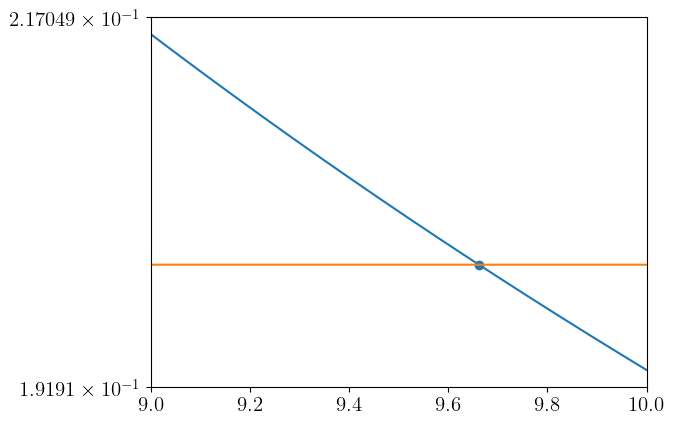

In [189]:
x = np.linspace(9, 10, 10000)
H_eval = HilbertTransform(lmbda)(x)
jmp_pts = np.concatenate([[0], np.where(np.diff(np.sign(H_eval)) > 0)[0]+1, [len(x)-1]])
#for i in range(len(jmp_pts)-1):
#    plt.plot(x[jmp_pts[i]:jmp_pts[i+1]], H_eval[jmp_pts[i]:jmp_pts[i+1]])
plt.plot(x, H_eval)
plt.plot(x, (c1*x+c0_re)/math.pi)
plt.scatter(mu.atoms, (c1*mu.atoms+c0_re)/math.pi)
plt.xlim(9, 10)
#plt.ylim(-1, 1)
plt.yscale('symlog')
plt.show()

In [243]:
if mu.density is not None:
    nodes = 100000
    mu_min = -100
    mu_max = 100

    # Complicated adaptive quadrature approach
    # only used when c0 complex (positive imaginary part)
    bin_edges = np.concatenate([[mu_min], lmbda_a[np.logical_and(lmbda_a > mu_min, lmbda_a < mu_max)], [mu_max]])

    pts, wts = trap_quad(0, 1, nodes)
    #pts, wts = leggauss_quad(0, 1, nodes) # nodes shouldn't exceed 1000 for leggauss

    quad_pts = np.reshape(bin_edges[:-1, None] + (bin_edges[1:, None] - bin_edges[:-1, None])*pts[None, :], -1)
    quad_wts = np.tile(wts, len(bin_edges)-1) * np.repeat(bin_edges[1:] - bin_edges[:-1], nodes)

    # Simple trapezoid quadrature approach
    quad_pts, quad_wts = trap_quad(mu_min, mu_max, int(1e5))

    mu.update_quadrature(quad_pts, quad_wts)

In [244]:
J = complex_exp_kernel(mu, t)

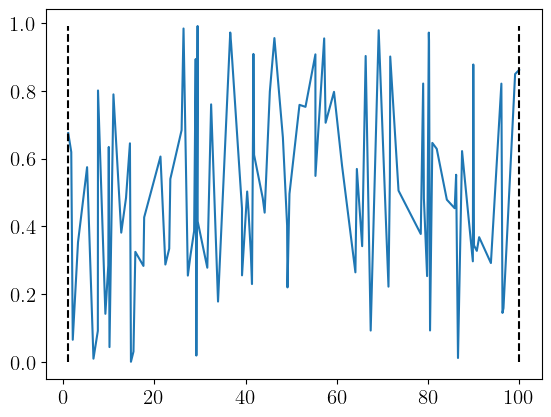

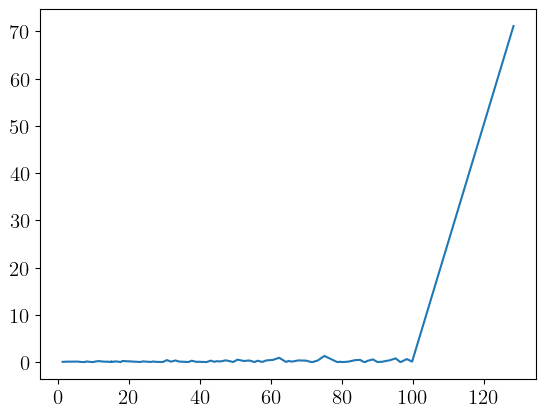

In [245]:
plt.plot(lmbda_trunc.atoms, lmbda_trunc.atom_wts)
#plt.plot(lmbda_a, lmbda_b)
plt.vlines([lmbda_a[left_endpoint], lmbda_a[right_endpoint-1]], ymin=0, ymax=np.max(lmbda_trunc.atom_wts), linestyle="dashed", color="k")
#plt.xscale("symlog")
#plt.yscale("log")
plt.show()

if mu.density is not None:
    plt.plot(mu.quad_pts, mu.density_vals)
    plt.vlines(bin_edges, ymin=np.min(lmbda.atom_wts), ymax=np.max(lmbda.atom_wts), linestyle="dashed", color="k")
    #plt.xscale("symlog")
    #plt.yscale("log")
    plt.show()
else:
    plt.plot(mu.atoms, mu.atom_wts)
    #plt.xscale("symlog")
    #plt.yscale("log")
    plt.show()

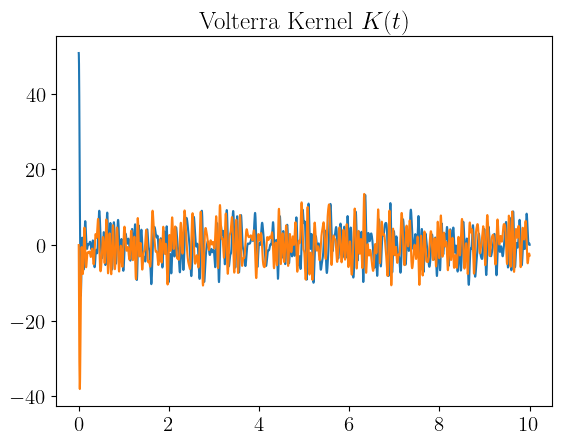

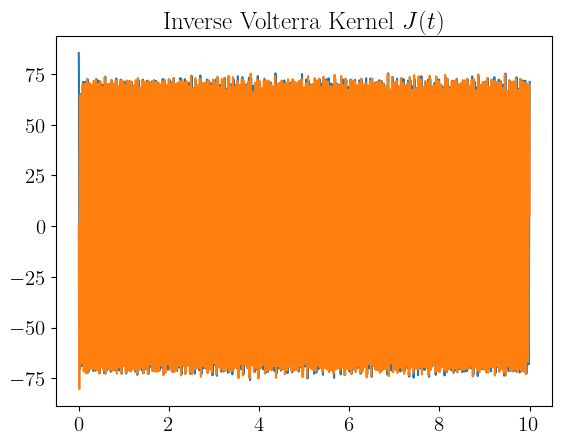

In [246]:
plt.title("Volterra Kernel $K(t)$")
plt.plot(t, np.real(K))
plt.plot(t, np.imag(K))
plt.show()

#J[t > 0.5] = 0

plt.title("Inverse Volterra Kernel $J(t)$")
plt.plot(t, np.real(J))
plt.plot(t, np.imag(J))
plt.show()

### Perform deconvolution using numerical quadrature

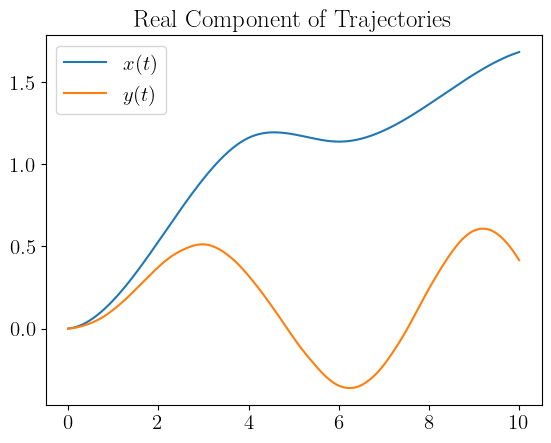

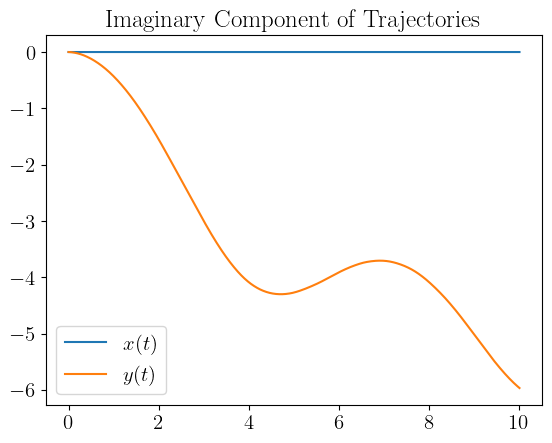

In [247]:
n_interp = 5
interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.CubicSpline(interp_ts, interp_xs)
x = cs(t)

xdot = np.gradient(x, dt)
y = c1*xdot - 1j*c0*x + conv_trap(K, x, t)

plt.plot(t, np.real(x))
plt.plot(t, np.real(y))
plt.title("Real Component of Trajectories")
plt.legend(["$x(t)$", "$y(t)$"])
plt.show()

plt.plot(t, np.imag(x))
plt.plot(t, np.imag(y))
plt.title("Imaginary Component of Trajectories")
plt.legend(["$x(t)$", "$y(t)$"])
plt.show()

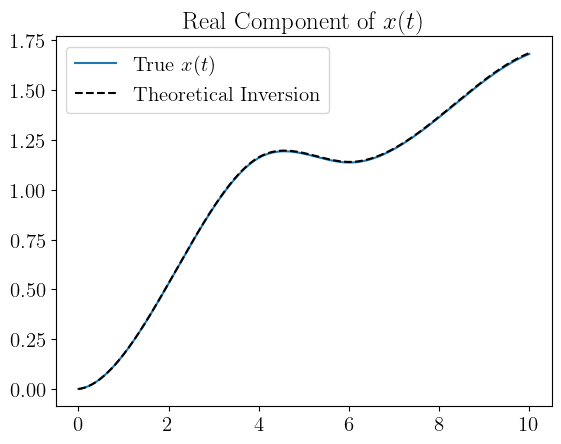

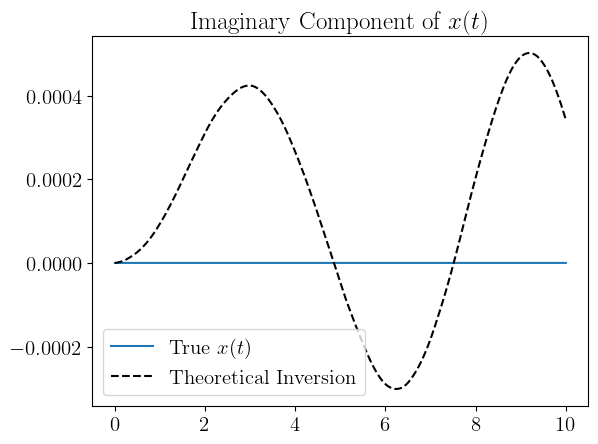

0.0027047866533101714


In [248]:
ydot = np.gradient(y, dt)
x_solve = zeta1*ydot - 1j*zeta0*y + conv_trap(J, y, t)

plt.plot(t, np.real(x))
plt.plot(t, np.real(x_solve), color="black", linestyle="dashed")
plt.title("Real Component of $x(t)$")
plt.legend(["True $x(t)$", "Theoretical Inversion"])
plt.show()

plt.plot(t, np.imag(x))
plt.plot(t, np.imag(x_solve), color="black", linestyle="dashed")
plt.title("Imaginary Component of $x(t)$")
plt.legend(["True $x(t)$", "Theoretical Inversion"])
plt.show()

print(np.linalg.norm(x - x_solve) / np.linalg.norm(x))

In [110]:
zeta1

0.0

In [ ]:
1/(-1j*c0)

(0.5+0.5j)

In [ ]:
zeta0/math.pi**2

(0.05066059182116889+0.05066059182116889j)

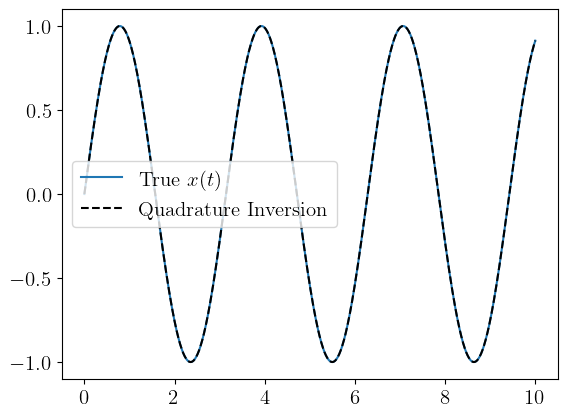

1.8030841126757257e-16


In [ ]:
assert(c1 == 0)

x_solve = solve_volterra_second_type(K, c0, y, t)

plt.plot(t, x)
plt.plot(t, x_solve, color="black", linestyle="dashed")
plt.legend(["True $x(t)$", "Quadrature Inversion"])
plt.show()

print(np.linalg.norm(x - x_solve) / np.linalg.norm(x))

In [ ]:
assert(c1 != 0)

y_interp = lambda s: np.interp(s, t, y)

solver = IDESolver(
    x = t,
    y_0 = 0,
    c = lambda x, y: c0/c1*y - y_interp(x)/c1,
    d = lambda x: -1/c1,
    k = lambda x, s: np.sum(lmbda_b*np.exp(-lmbda_a*(x-s))),
    f = lambda y: y,
    lower_bound = lambda x: 0,
    upper_bound = lambda x: x,
)

solver.solve()

AssertionError: 

### Future Work: Numerical Algorithm that Searches for Roots in the Complex Plane, generalizes our approach to any linear higher-order integrodifferential Volterra equation

In [ ]:
x = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(x, x)

c0 = 0.9 + 0j
c1 = 1 + 0j

num_modes = 100
modes = -np.random.rand(num_modes//2) + 1j*np.random.rand(num_modes//2)
modes = np.concatenate((modes, np.conj(modes)))
weights = np.random.randn(num_modes//2)
weights = np.concatenate((weights, weights))

Z = c1*(X + 1j*Y) + c0 + np.sum(weights[None, None, :]/((X[:, :, None] + np.real(modes[None, None, :])) + 1j*(Y[:, :, None] + np.imag(modes[None, None, :]))), axis=2)

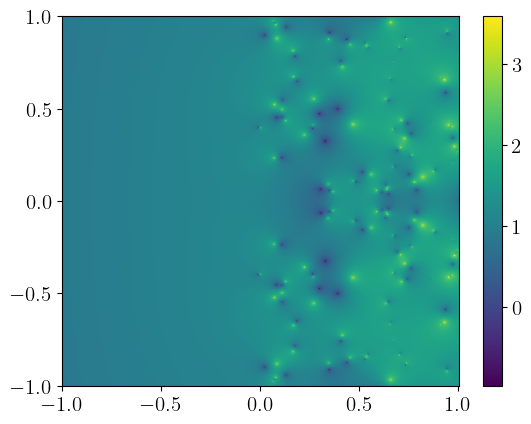

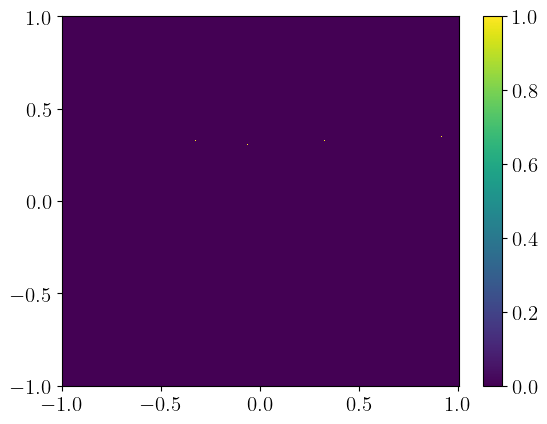

In [ ]:
plt.pcolormesh(x, x, np.log10(np.abs(Z)))
plt.colorbar()
plt.show()

plt.pcolormesh(x, x, np.abs(Z).T < 3e-1)
plt.colorbar()
plt.show()

In [4]:
import numpy as np
from scipy.interpolate import AAA
from scipy.special import gamma

sample_points = np.linspace(-1.5, 1.5, num=100)
r = AAA(sample_points, gamma(sample_points))
z = np.linspace(-3.5, 4.5, num=1000)
fig, ax = plt.subplots()
ax.plot(z, gamma(z), label="Gamma")
ax.plot(sample_points, gamma(sample_points), label="Sample points")
ax.plot(z, r(z).real, '--', label="AAA approximation")
ax.set(xlabel="z", ylabel="r(z)", ylim=[-8, 8], xlim=[-3.5, 4.5])
ax.legend()
plt.show()

ImportError: cannot import name 'AAA' from 'scipy.interpolate' (/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/__init__.py)

AAA failed to converge within 99 iterations.
[-1.00000000e-10 -1.04717682e-10  1.04717682e-10 -1.09657929e-10
  1.09657929e-10 -6.93171728e-10  1.38082977e-10 -1.38082977e-10
  1.25921561e-10 -1.25921561e-10  1.31862140e-10 -1.44597292e-10
  2.63281547e-10 -2.18947676e-10  6.61943346e-10 -7.95977700e-10
  9.57152154e-10 -2.19452909e-09  1.32166418e-09 -1.51768339e-09
  5.03154895e-09 -3.81576466e-09  7.97814457e-09 -1.00462042e-08
  8.35452806e-09 -1.82920450e-08  1.15361810e-08 -2.64498018e-08
  1.32777083e-07 -6.06432940e-08  6.35042517e-08 -9.18254284e-08
  5.53022426e-08 -5.29326606e-07  2.36250847e+03 -3.07955871e-02
  4.40193519e-07  3.65226736e-08  2.65720111e-06  4.44270675e-03
  9.77214697e-01  3.23228398e-01  3.38477286e-01  8.51000725e-01
  8.91148232e-01  5.35462090e-02  3.08666494e-01 -9.61574600e-08
 -4.39180089e-08 -1.83342548e-07 -4.60960449e-07 -3.18789129e-07
 -3.49577557e-07 -6.66536327e-07 -1.52821404e-06 -1.75486715e-06
 -8.39312950e-07 -9.22497005e-06  2.47396410e

/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


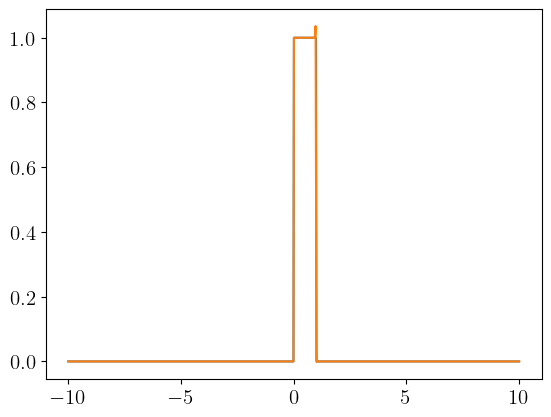

0.06546137912639127


In [199]:
zs = np.logspace(-10, 10, 1000)
zs = np.concatenate((-zs, zs))
#u = lambda x: np.exp(-x**2)
u = lambda x: (x > 0) & (x < 1)
u_eval = u(zs)
pol, res, zer, zj, fj, wj = aaa(zs, u_eval)

xs = np.linspace(-10, 10, 1000)
u_hat = np.sum(res[:, None]/(xs - pol[:, None]), axis=0)
#u_hat = np.sum((wj*fj)[:, None]/(xs - zj[:, None]), axis=0) / np.sum(wj[:, None]/(xs - zj[:, None]), axis=0)

plt.plot(xs, u(xs))
plt.plot(xs, u_hat)
plt.show()

print(np.linalg.norm(u(xs) - u_hat) / np.linalg.norm(u(xs)))

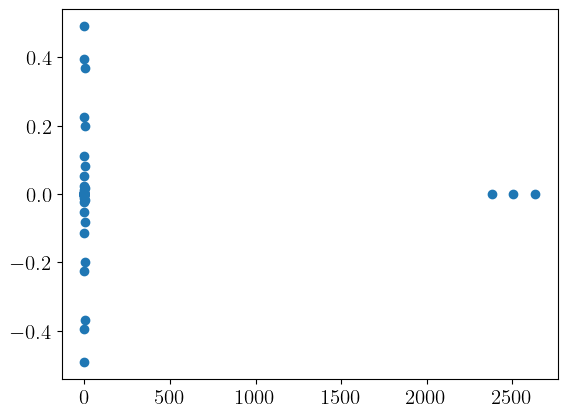

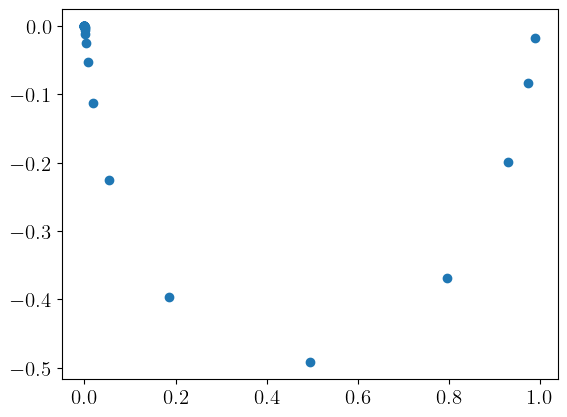

In [200]:
plt.scatter(pol.real, pol.imag)
plt.show()

pol = pol[np.imag(pol) < 0]

plt.scatter(pol.real, pol.imag)
plt.show()

d = np.min(np.abs(zs - pol[:, None]), axis=1)

In [201]:
A = d / (zs[:, None] - pol)
A = np.concatenate([np.real(A), -np.imag(A)], axis=1)
c = np.reshape(np.linalg.lstsq(A, u_eval, rcond=None)[0], (-1, 2), order='F') @ np.array([1, 1j])

f = lambda x: np.sum((c*d) / (x[:, None] - pol), axis=1)
Hu = lambda x: np.imag(f(x))

In [202]:
A.shape

(2000, 86)

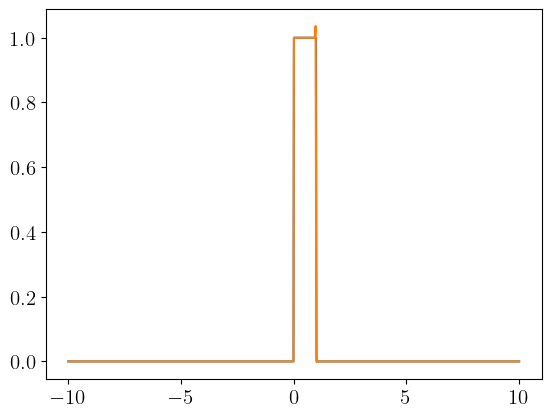

0.06545404281228019


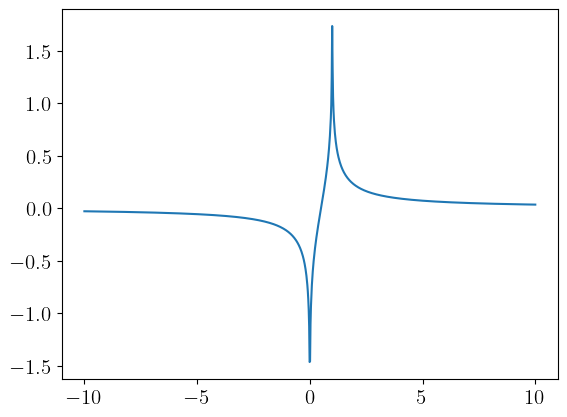

In [203]:
xs = np.linspace(-10, 10, 1000)

plt.plot(xs, u(xs))
plt.plot(xs, np.real(f(xs)))
plt.show()

print(np.linalg.norm(u(xs) - np.real(f(xs))) / np.linalg.norm(u(xs)))

plt.plot(xs, Hu(xs))
plt.show()

In [208]:
H = 1/math.pi*np.log(np.abs(xs/(1-xs)))
print(np.linalg.norm(H - np.real(Hu(xs))) / np.linalg.norm(H))


0.046163693674341366


In [6]:
#lmbda = Distribution(lambda x: np.exp(-x**2/10))
#lmbda = Distribution(None, np.random.randn(3), np.random.rand(3))
#lmbda = Distribution(lambda x: np.exp(-np.abs(x)/10), np.random.randn(2), np.random.rand(2))

def density(x):
    y = np.exp(-(x+10)**2/10) + np.exp(-(x - 10)**2/10)
    y *= y > 0.1
    return y

quad_pts, quad_wts = trap_quad(-30, 30, 1000)
lmbda = Distribution(density, np.random.randn(2), np.random.rand(2), quad_pts, quad_wts)

H = HilbertTransform(lmbda, aaa_iters = 200)

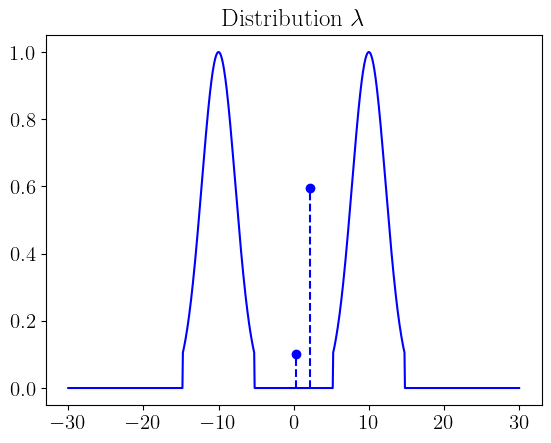

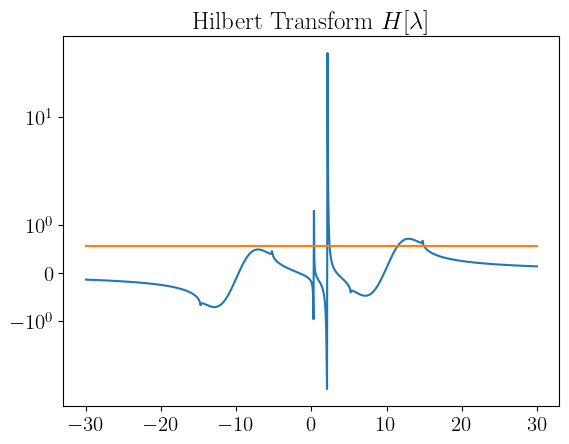

In [7]:
plt.title("Distribution $\lambda$")
if lmbda.density is not None:
    plt.plot(lmbda.quad_pts, lmbda.density_vals, color="blue")
plt.scatter(lmbda.atoms, lmbda.atom_wts, marker='o', color="blue")
plt.vlines(lmbda.atoms, ymin=0, ymax=lmbda.atom_wts, linestyle='--', color="blue")
plt.show()

plt.title("Hilbert Transform $H[\lambda]$")
plt.plot(lmbda.quad_pts, H(lmbda.quad_pts))
plt.plot(lmbda.quad_pts, (c1*lmbda.quad_pts + c0_re)/math.pi)
plt.yscale("symlog")
plt.show()

In [8]:
H.roots(c1/math.pi, c0_re/math.pi)

array([-5.25525526,  0.3539323 ,  2.41569647, 14.96030522])

In [9]:
c0 = -1 + 1j
c1 = 0
mu, zeta0, zeta1 = invert_volterra_pd(lmbda, c0, c1, H=H)
quad_pts, quad_wts = trap_quad(-200, 200, 100000)
mu.update_quadrature(quad_pts, quad_wts)

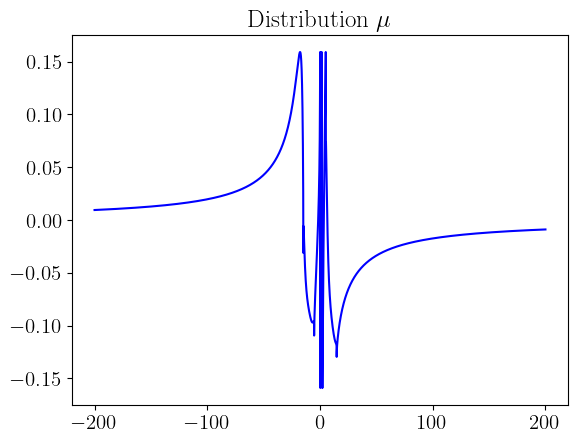

In [10]:
plt.title("Distribution $\mu$")
if mu.density is not None:
    plt.plot(mu.quad_pts, mu.density_vals, color="blue")
plt.scatter(mu.atoms, mu.atom_wts, marker='o', color="blue")
plt.vlines(mu.atoms, ymin=0, ymax=mu.atom_wts, linestyle='--', color="blue")
plt.show()

In [11]:
K = complex_exp_kernel(lmbda, t)
J = complex_exp_kernel(mu, t)

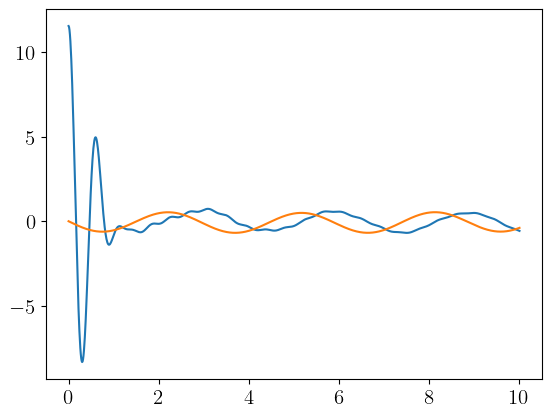

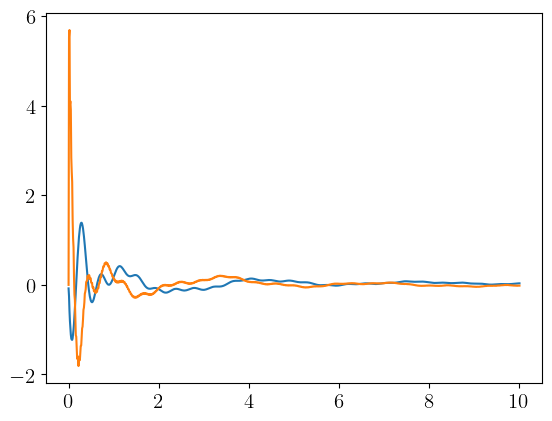

In [12]:
plt.plot(t, np.real(K))
plt.plot(t, np.imag(K))
plt.show()

plt.plot(t, np.real(J))
plt.plot(t, np.imag(J))
plt.show()

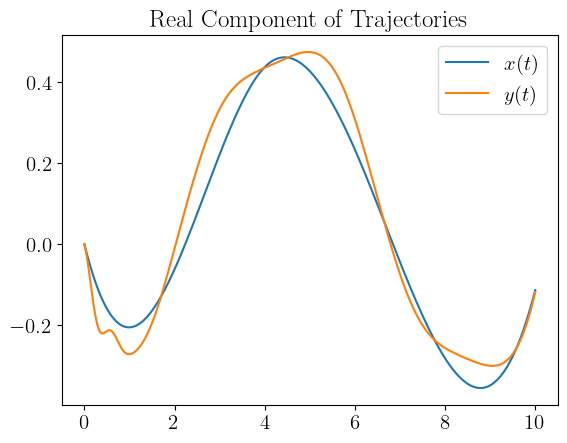

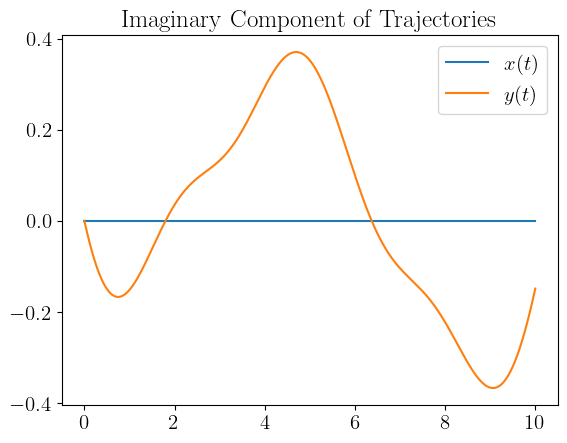

In [13]:
n_interp = 5
interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.CubicSpline(interp_ts, interp_xs)
x = cs(t)

xdot = np.gradient(x, dt)
y = c1*xdot - 1j*c0*x + conv_trap(K, x, t)

plt.plot(t, np.real(x))
plt.plot(t, np.real(y))
plt.title("Real Component of Trajectories")
plt.legend(["$x(t)$", "$y(t)$"])
plt.show()

plt.plot(t, np.imag(x))
plt.plot(t, np.imag(y))
plt.title("Imaginary Component of Trajectories")
plt.legend(["$x(t)$", "$y(t)$"])
plt.show()

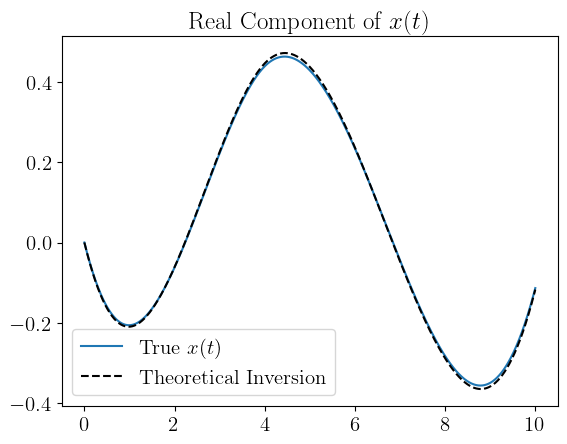

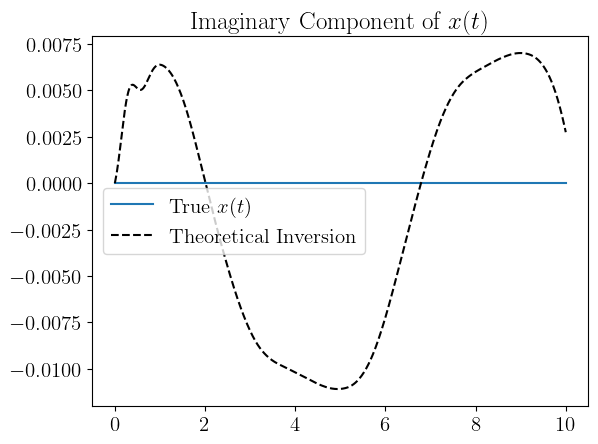

0.03237941439196461


In [14]:
ydot = np.gradient(y, dt)
x_solve = zeta1*ydot - 1j*zeta0*y + conv_trap(J, y, t)

plt.plot(t, np.real(x))
plt.plot(t, np.real(x_solve), color="black", linestyle="dashed")
plt.title("Real Component of $x(t)$")
plt.legend(["True $x(t)$", "Theoretical Inversion"])
plt.show()

plt.plot(t, np.imag(x))
plt.plot(t, np.imag(x_solve), color="black", linestyle="dashed")
plt.title("Imaginary Component of $x(t)$")
plt.legend(["True $x(t)$", "Theoretical Inversion"])
plt.show()

print(np.linalg.norm(x - x_solve) / np.linalg.norm(x))